# Retail Sales Forecasting - 3 of 5

## Tree-based algorithms - XGBoost

XGBoost is one of the more popular tree-based machine learning algorithms. Let's see how it performs on this relatively small data set.  

### Notebook Setup

In [1]:
%matplotlib inline

from __future__ import division
from __future__ import print_function

# ignore deprecation warnings in sklearn
import warnings
warnings.filterwarnings("ignore")

# Import Pandas, Matplotlib, etc
from math import sqrt

import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

from statsmodels.graphics.tsaplots import plot_acf

# Homegrown utilities for making lags, back testing, etc.
from lag_transformer import LagTransformer
from lag_cleaner import LagCleaner
from walksplit import TimeSeriesWalkSplit
from back_test import walk_forward_validate, calc_metrics, get_first_sunday, get_default_train_test_size

plt.style.use('ggplot')

### Load Sales Data

In [2]:
df_in = pd.read_excel('../data/daily-sales.xlsx', index_col='date', parse_dates=True)
df_in.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2017-11-17 to 2018-11-17
Data columns (total 9 columns):
year          366 non-null int64
month         366 non-null object
week          366 non-null int64
day           366 non-null object
is_open       366 non-null int64
is_holiday    366 non-null int64
sales         366 non-null float64
customers     366 non-null int64
avg_sale      366 non-null float64
dtypes: float64(2), int64(5), object(2)
memory usage: 28.6+ KB


### Get Dummies

In [3]:
# Convert days into binary flags and drop the month
df_sales = df_in.drop(['year', 'month', 'week', 'customers', 'avg_sale'], axis='columns')
df_sales = pd.get_dummies(df_sales)

df_sales.head()

,is_open,is_holiday,sales,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed
date,,,,,,,,,,
2017-11-17,1,0,348.63,1,0,0,0,0,0,0
2017-11-18,1,0,1334.38,0,0,1,0,0,0,0
2017-11-19,0,0,0.00,0,0,0,1,0,0,0
2017-11-20,1,0,512.08,0,1,0,0,0,0,0
2017-11-21,1,0,0.00,0,0,0,0,0,1,0


In [4]:
df_sales['sales'].describe()

count     366.000000
mean      710.298661
std       628.412676
min         0.000000
25%       240.267500
50%       559.600000
75%      1060.692500
max      3493.050000
Name: sales, dtype: float64

### Make Lags & Merge with the Dummy Day Features

In [5]:
y_col = 'sales'
x_cols = ['sales']
lags = [7, 28]

trans = LagTransformer(x_cols=x_cols, y_col=y_col, lags=lags)
df_lag = trans.transform(df_in)

# Clean the lagged data to remove the cases where sales from a closed
# day are being used to forecast an open day or vice-versa.
clean = LagCleaner()
df_lag = clean.fit_transform(df_lag)

df = pd.concat([df_lag, df_sales], axis='columns')
df.drop(['sales'], axis='columns', inplace=True)
df.dropna(inplace=True)

# Trim off the first few rows so we start on a Sunday
start_idx = get_first_sunday(df)
if start_idx > 0:
    df.drop(df.index[:start_idx], inplace=True)

df.tail(10)

,sales_t-28,sales_t-7,y,is_open,is_holiday,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed
date,,,,,,,,,,,,
2018-11-08,214.51,656.54,388.11,1,0,0,0,0,0,1,0,0
2018-11-09,710.11,1097.56,849.25,1,0,1,0,0,0,0,0,0
2018-11-10,1552.04,1780.13,2007.19,1,0,0,0,1,0,0,0,0
2018-11-11,0.00,0.00,0.00,0,1,0,0,0,1,0,0,0
2018-11-12,1426.70,669.57,1220.64,1,1,0,1,0,0,0,0,0
2018-11-13,419.39,431.19,678.82,1,0,0,0,0,0,0,1,0
2018-11-14,1128.09,531.03,300.02,1,0,0,0,0,0,0,0,1
2018-11-15,956.26,388.11,658.48,1,0,0,0,0,0,1,0,0
2018-11-16,1337.40,849.25,178.64,1,0,1,0,0,0,0,0,0


### Back Test XGBoost

In [6]:
fixed_params = {
    'objective': 'reg:linear',
    'random_state': 0
}

model = xgb.XGBRegressor(**fixed_params)

df_pred = walk_forward_validate(model, df)
df_m = calc_metrics(df_pred)
weeks = len(df_m.index)

print('MAPE for {:d} week steps = {:.2f}%'.format(weeks, df_m['MAPE'].mean()))
print('RMSE for {:d} week steps = {:.2f}'.format(weeks, df_m['RMSE'].mean()))

MAPE for 32 week steps = 21.65%
RMSE for 32 week steps = 504.43


### Visualize Forecast vs Actual Sales

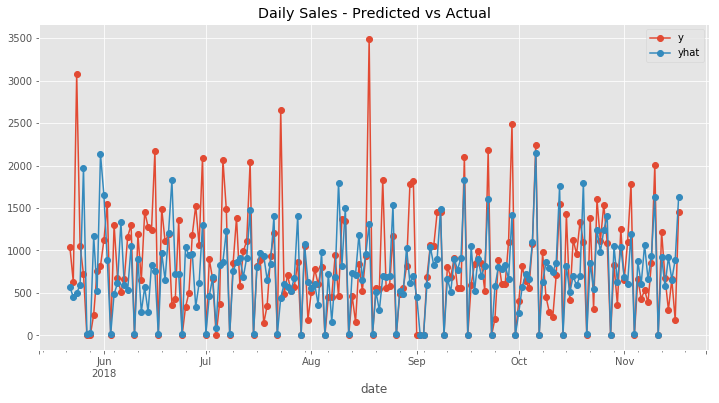

In [7]:
df_fcst = df_pred[['y', 'yhat']][-180:]
df_fcst.plot(figsize=(12, 6), marker='o')
plt.title('Daily Sales - Predicted vs Actual')
plt.show()

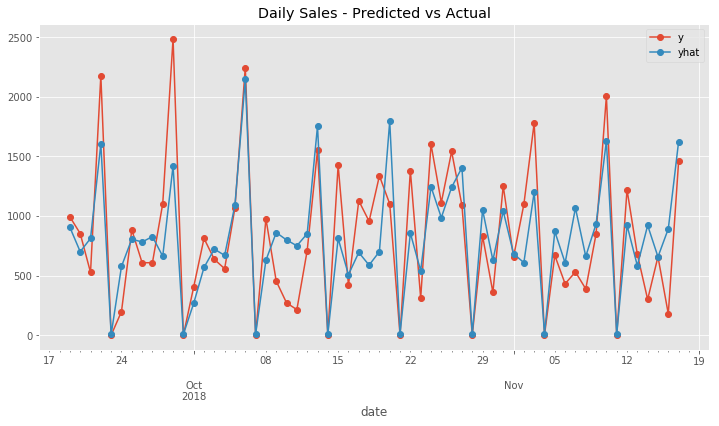

In [8]:
latest_df = df_pred[['y', 'yhat']][-60:]
latest_df.plot(figsize=(12, 6), marker='o')
plt.title('Daily Sales - Predicted vs Actual')
plt.show()

In [9]:
df_m.tail(12)

,MAPE,RMSE
date,,
2018-08-26,30.060493,642.318254
2018-09-02,14.815187,227.595249
2018-09-09,0.115374,205.644240
2018-09-16,6.468103,328.964030
2018-09-23,13.722073,472.420879
2018-09-30,4.402202,124.685150
2018-10-07,35.262465,361.557771
2018-10-14,19.839429,477.366611
2018-10-21,10.645811,307.503283


### Most Important Features

One of the handy things about tree-based algorithms like XGBoost is that it's easy to see which features led to the most splits and are considered most important.

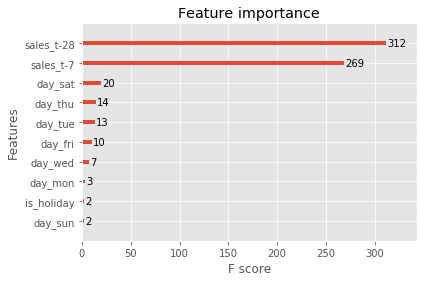

In [10]:
# Plot the feature importance
xgb.plot_importance(model)
plt.show()

### Hyper Parameter Tuning

XGBoost has a wealth of tunable hyper parameters. Try tuning a few of the more important ones like max_depth and n_estimators to get see if we can get better performance. 

**Note:**

Know that running the grid search below will take a few minutes so be patient after you hit 'run'.  You'll see a message from XGBoost when the grid search is finished.

In [11]:
X = df.drop('y', axis='columns')
y = df[['y']]

min_train_size, test_size = get_default_train_test_size()
ts_split = TimeSeriesWalkSplit(test_size, train_size=min_train_size)

param_grid = {
    'max_depth': [1, 2, 5],
    'colsample_bytree': [0.1, 0.5, 0.8, 1.0],
    'min_child_weight': [2, 3, 4],
    'n_estimators': [20, 50, 75, 100]
}

model = xgb.XGBRegressor(model, random_state=0)

ts_cv = GridSearchCV(model, param_grid, n_jobs=10, cv=ts_split, scoring='neg_mean_squared_error', verbose=1)
ts_cv.fit(X, y)
rmse = sqrt(ts_cv.best_score_ * -1.0)
best = ts_cv.best_params_

print('Best params: {}'.format(best))
print('Best score: {}'.format(rmse))

Fitting 32 folds for each of 144 candidates, totalling 4608 fits


[Parallel(n_jobs=10)]: Done 140 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 1940 tasks      | elapsed:    4.8s


Best params: {'colsample_bytree': 0.5, 'max_depth': 1, 'min_child_weight': 4, 'n_estimators': 50}
Best score: 509.95285961720305


[Parallel(n_jobs=10)]: Done 4608 out of 4608 | elapsed:   11.6s finished


In [12]:
# Re-test with optimized prarams
model = xgb.XGBRegressor(**fixed_params, **best)

df_pred2 = walk_forward_validate(model, df)
df_m = calc_metrics(df_pred2)
weeks = len(df_m.index)

print('MAPE for {:d} week steps = {:.2f}%'.format(weeks, df_m['MAPE'].mean()))
print('RMSE for {:d} week steps = {:.2f}'.format(weeks, df_m['RMSE'].mean()))

df_m.tail(12)

MAPE for 32 week steps = 19.51%
RMSE for 32 week steps = 461.37


,MAPE,RMSE
date,,
2018-08-26,26.124000,638.105315
2018-09-02,15.238243,205.331039
2018-09-09,1.463595,345.091123
2018-09-16,10.708223,340.008643
2018-09-23,6.532495,479.111013
2018-09-30,9.691300,301.285306
2018-10-07,25.330775,325.356863
2018-10-14,24.464492,451.862497
2018-10-21,20.451083,442.100530


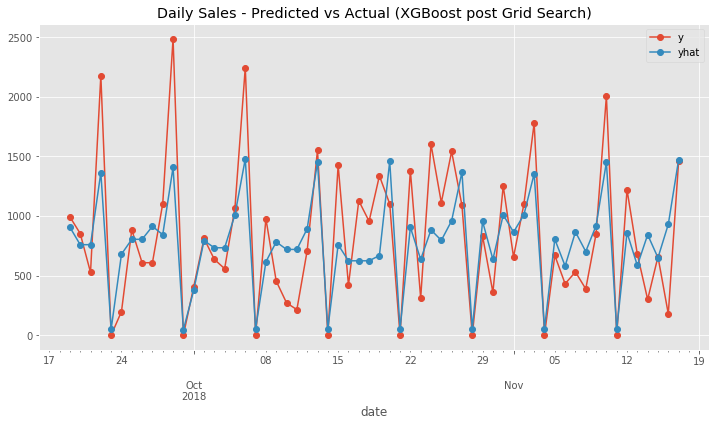

In [13]:
latest_df = df_pred2[['y', 'yhat']][-60:]
latest_df.plot(figsize=(12, 6), marker='o')
plt.title('Daily Sales - Predicted vs Actual (XGBoost post Grid Search)')
plt.show()

### Conclusion

To recap, here's the baseline score

And here's the score from Elastic Net

XGBoost didn't perform quite as well on this small data set and was more difficult to tune. It did, however, provide really useful insight into what features were most important.